# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will answer one question for the new traveller to a specific city: where to find the optimal location for the specific type of restaurant you prefer. Specifically, the report will be targeted to travellers interested in finding **Asian restaurant** in **New York**, US.


Since there are lots of restaurants in New York we will try to detect **locations that are crowded with restaurants**, group locations **into different types**, choose Asian-type locations **as close to city center as possible**.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible location can be chosen by travellers.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of and distance to Asian restaurants in the neighborhood, if any
* distance of neighborhood from city center

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Restaurants in New York

Let's use geopy library to get the latitude and longitude values of New York City. We will explore all the venues within 5km to the center of the city. Then use all the restuarants in New York to create our dataframe.

In [43]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Create a map of New York with a 30km circle.

In [93]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
label = folium.Popup('Center', parse_html=True)
folium.Circle(
    [latitude, longitude],
    radius=20000,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.2,
    parse_html=False).add_to(map_newyork)  
    
map_newyork

Now let's create a grid of area candidates, equaly spaced, centered around city center and within ~6km from Alexanderplatz. Our neighborhoods will be defined as circular areas with a radius of 300 meters, so our neighborhood centers will be 600 meters apart.

To accurately calculate distances we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in  meters).

In [82]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=18, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=18, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('New York center longitude={}, latitude={}'.format(longitude, latitude))
x, y = lonlat_to_xy(longitude, latitude)
print('New York center UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('New York center longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
New York center longitude=-74.0060152, latitude=40.7127281
New York center UTM X=583958.1787429522, Y=4507343.002348409
New York center longitude=-74.0060152, latitude=40.71272809999999


/Users/lakerhoo/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  if sys.path[0] == '':
/Users/lakerhoo/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


Let's create a **hexagonal grid of cells**: we offset every other row, and adjust vertical row spacing so that **every cell center is equally distant from all it's neighbors**.

In [ ]:
city_x, city_y = lonlat_to_xy(longitude, latitude)

dis=600
lim=20000
num=int(lim/dis)*2+1

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = city_x - lim
x_step = dis
y_min = city_y - lim - (int(num/k)*k*dis - lim*2)/2
y_step = dis * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(num/k)):
    y = y_min + i * y_step
    x_offset = dis/2 if i%2==0 else 0
    for j in range(0, num):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(city_x, city_y, x, y)
        if (distance_from_center <= lim+10):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

In [95]:
print(len(latitudes), 'candidate neighborhood centers generated.')

4031 candidate neighborhood centers generated.


In [96]:
map_new = folium.Map(location=[latitude, longitude], zoom_start=10)
folium.Marker([latitude, longitude], popup='New York').add_to(map_new)
for lat, lon in zip(latitudes, longitudes):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_new)
    #folium.Marker([lat, lon]).add_to(map_berlin)
folium.Circle(
    [latitude, longitude],
    radius=lim,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.2,
    parse_html=False).add_to(map_new)  
    
map_new

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on restaurants in each neighborhood.

We're interested in venues in 'food' category, but only those that are proper restaurants - coffe shops, pizza places, bakeries etc. are not direct competitors so we don't care about those. So we will include in out list only venues that have 'restaurant' in category name

Foursquare credentials are defined in hidden cell bellow.

In [97]:
CLIENT_ID = '54WPKLXWPOYFEPO5NAENC4M23NDR5D5XBJ2WKC3HAUPZWDP5' # your Foursquare ID
CLIENT_SECRET = 'VFAHGXG0MVJYGOZIEE3KYROMJNL4IG515J02XGVRHVFC3XAF' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 54WPKLXWPOYFEPO5NAENC4M23NDR5D5XBJ2WKC3HAUPZWDP5
CLIENT_SECRET:VFAHGXG0MVJYGOZIEE3KYROMJNL4IG515J02XGVRHVFC3XAF


In [ ]:
radius = 600 # 30km range
LIMIT = 200
name_list = []
cat_list = []
lat_list = []
lng_list = []

for ii in len(latitudes), desc='Loop:':
    lat = latitudes[ii]
    lon = longitudes[ii]
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lon, 
        radius, 
        LIMIT)
    results = requests.get(url).json()
    try:
        venues = results['response']['groups'][0]['items']
    except:
        continue
    if not venues: continue
    
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    name_list += nearby_venues.iloc[:,0].values.tolist()
    cat_list += nearby_venues.iloc[:,1].values.tolist()
    lat_list += nearby_venues.iloc[:,2].values.tolist()
    lng_list += nearby_venues.iloc[:,3].values.tolist()

In [143]:
len(name_list)

6525

In [147]:
import pandas as pd

df = pd.DataFrame({'Address': name_list,
                             'Category': cat_list,
                             'Latitude': lat_list,
                             'Longitude': lng_list,
                             })

df.head(10)
df.to_csv('/Users/lakerhoo/Downloads/ny_venues.csv', index=False)

In [148]:
df.shape

(6525, 4)

In [163]:
items = df['Category'].unique().tolist()

rest_name = []
for ii in items:
    if 'Restaurant' in ii:
        rest_name.append(ii)

In [164]:
rest_name

['Restaurant',
 'Japanese Restaurant',
 'Fast Food Restaurant',
 'American Restaurant',
 'Italian Restaurant',
 'Asian Restaurant',
 'Mexican Restaurant',
 'Dim Sum Restaurant',
 'Sushi Restaurant',
 'Seafood Restaurant',
 'Vietnamese Restaurant',
 'Chinese Restaurant',
 'Indian Restaurant',
 'Russian Restaurant',
 'Vegetarian / Vegan Restaurant',
 'French Restaurant',
 'Eastern European Restaurant',
 'Caribbean Restaurant',
 'Latin American Restaurant',
 'Falafel Restaurant',
 'Middle Eastern Restaurant',
 'Mediterranean Restaurant',
 'Korean Restaurant',
 'Turkish Restaurant',
 'Greek Restaurant',
 'New American Restaurant',
 'Polish Restaurant',
 'German Restaurant',
 'Caucasian Restaurant',
 'Cantonese Restaurant',
 'Peruvian Restaurant',
 'Shanghai Restaurant',
 'Spanish Restaurant',
 'Halal Restaurant',
 'Malay Restaurant',
 'Hong Kong Restaurant',
 'Thai Restaurant',
 'Tex-Mex Restaurant',
 'Filipino Restaurant',
 'Hotpot Restaurant',
 'Burmese Restaurant',
 'Kosher Restaurant',

In [222]:
rest_name = ['Japanese Restaurant', 'Asian Restaurant', 'Chinese Restaurant', 'Sushi Restaurant', 'Vietnamese Restaurant', 'Korean Restaurant', 'Shanghai Restaurant', 'Cantonese Restaurant', 'Hong Kong  Restaurant', 'Thai Restaurant']
df_rest = df[df['Category'].isin(rest_name)]
df_rest.shape

(395, 4)

In [223]:
df_rest.head(5)

,Address,Category,Latitude,Longitude
84,Hokkaido Japanese Restaurant,Japanese Restaurant,40.560886,-74.135522
111,Empire East,Asian Restaurant,40.565043,-74.114294
217,Island Taste,Asian Restaurant,40.563872,-74.132656
248,Taste Of China,Asian Restaurant,40.564515,-74.127992
254,Empire East,Asian Restaurant,40.565043,-74.114294


In [ ]:
lons = df_rest['Longitude'].values
lats = df_rest['Latitude'].values
xs = []
ys = []
distances = []
for lon, lat in zip(lons, lats):
    x, y = lonlat_to_xy(lon, lat)
    xs.append(x)
    ys.append(y)
    distances.append(calc_xy_distance(city_x, city_y, x, y))

In [225]:
df_rest.insert(4, "X", xs, True)
df_rest.insert(5, "Y", ys, True)
df_rest.insert(6, "Distance", distances, True)
df_rest.head()

,Address,Category,Latitude,Longitude,X,Y,Distance
84,Hokkaido Japanese Restaurant,Japanese Restaurant,40.560886,-74.135522,573184.723367,4.490372e+06,20101.705443
111,Empire East,Asian Restaurant,40.565043,-74.114294,574977.233834,4.490851e+06,18778.452952
217,Island Taste,Asian Restaurant,40.563872,-74.132656,573424.092689,4.490706e+06,19691.569080
248,Taste Of China,Asian Restaurant,40.564515,-74.127992,573818.216986,4.490781e+06,19419.340648
254,Empire East,Asian Restaurant,40.565043,-74.114294,574977.233834,4.490851e+06,18778.452952


Normalize X and Y for further clustering

In [ ]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

min_max_scaler = preprocessing.MinMaxScaler()
df_rest['X'] = min_max_scaler.fit_transform(df_rest[['X']].values)[:,0]
df_rest['Y'] = min_max_scaler.fit_transform(df_rest[['Y']].values)[:,0]
df_rest.head()

In [236]:
from sklearn.metrics import silhouette_score
krange = list(range(2,11))
scores = []
# set number of clusters
for kclusters in krange:

    # run k-means clustering
    test = df_rest[['Latitude', 'Longitude']]
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(test)

    # check cluster labels generated for each row in the dataframe
    scores.append(silhouette_score(test, kmeans.labels_))

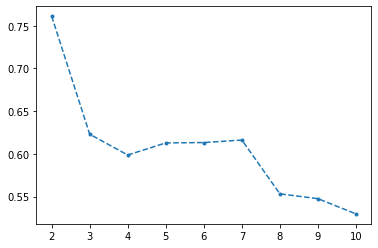

In [237]:
import matplotlib.pylab as plt
plt.figure()
plt.plot(krange, scores,'.--')

Then we choose k=7 for kmeans clusterings.

In [240]:
kclusters = 7
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_rest[['X', 'Y']])
df_rest['Type'] = kmeans.labels_
df_rest.head(5)

,Address,Category,Latitude,Longitude,X,Y,Distance,Type
84,Hokkaido Japanese Restaurant,Japanese Restaurant,40.560886,-74.135522,0.102673,0.000000,20101.705443,5
111,Empire East,Asian Restaurant,40.565043,-74.114294,0.162469,0.075468,18778.452952,5
217,Island Taste,Asian Restaurant,40.563872,-74.132656,0.110658,0.052568,19691.569080,5
248,Taste Of China,Asian Restaurant,40.564515,-74.127992,0.123806,0.064421,19419.340648,5
254,Empire East,Asian Restaurant,40.565043,-74.114294,0.162469,0.075468,18778.452952,5


In [242]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_rest['Latitude'], df_rest['Longitude'], df_rest['Category'], df_rest['Type']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters